##### Detección de tópicos en ciencia básica: topicos con modelo entrenado

1. Filtrar documentos
2. Aplicar tf-idf
3. Guardar



#### **To do** 
- detectar en inngles
- Documentos repetidos entre repositorios y convocatorias
- mismo proyecto 
-


In [1]:
import pickle

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from math import sqrt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize, word_tokenize

import heapq
import seaborn as sns

nltk.download('wordnet')
nltk.download('punkt')

stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danielbustillos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielbustillos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
df_texto_eval = pd.read_csv("./data/procesado/por_topico/data_training.csv")
df_texto_eval = df_texto_eval.reset_index(drop=True)
df_texto_eval.head()

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,USUARIO,CVU,NOMBRE,CVE_RCEA,AREA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,DEPENDENCIA,SUBDEPENDENCIA,DESCRIPCION_PROYECTO,PALABRAS_CLAVE1,PALABRAS_CLAVE2,PALABRAS_CLAVE3
0,1105,PROBLEMAS-2015-01,2015,X_jpena904,904,JUAN JOSE PE?A CABRIALES,RCEA-06-06773-2002,CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...,MATEMATICAS,NaN,CENTRO DE INVESTIGACION Y DE ESTUDIOS AVANZADO...,MEX,DF,UNIDAD IRAPUATO,DEPARTAMENTO DE BIOTECNOLOGIA Y BIOQUIMICA,mund actual alt dinam complej condicion socioa...,Inteligencia artificial,Agricultura urbana y periurbana,Sistema de soporte de decisiones
1,1105,PROBLEMAS-2015-01,2015,X_hmorales22194,22194,HELDA ELEONORA DE GUADALUPE MORALES,RCEA-06-11606-2006,CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...,MATEMATICAS,NaN,EL COLEGIO DE LA FRONTERA SUR,MEXICO,CHIAPAS,UNIDAD SAN CRISTOBAL DE LAS CASAS,UNIDAD SAN CRISTOBAL DE LAS CASAS,mund actual alt dinam complej condicion socioa...,Inteligencia artificial,Agricultura urbana y periurbana,Sistema de soporte de decisiones
2,1105,PROBLEMAS-2015-01,2015,X_aperez58970,58970,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,CAMPUS VERACRUZ,CAMPUS VERACRUZ,mund actual alt dinam complej condicion socioa...,Inteligencia artificial,Agricultura urbana y periurbana,Sistema de soporte de decisiones
3,1775,PROBLEMAS-2015-01,2015,X_gordonez11603,11603,GERARDO MANUEL ORDO?EZ BARBA,RCEA-05-06026-2003,CIENCIAS SOCIALES,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,polit public enfrent pobrez extrem mediant dis...,Pobreza extrema,Seguridad alimentaria,Perdidas y desperdicios de alimentos
4,1775,PROBLEMAS-2015-01,2015,X_facosta12725,12725,FELIX ACOSTA DIAZ,RCEA-05-06058-2003,CIENCIAS SOCIALES,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,DIRECCION GENERAL ACADEMICA,DIRECCION GENERAL ACADEMICA,polit public enfrent pobrez extrem mediant dis...,Pobreza extrema,Seguridad alimentaria,Perdidas y desperdicios de alimentos


In [14]:
texto = df_texto_eval["DESCRIPCION_PROYECTO"]

In [15]:
df_texto_eval = df_texto_eval.drop_duplicates(subset=["ID_PROYECTO","NUMERO_CONVOCATORIA","ANIO"], keep="last")

#### obtener tfidf
 regresa matriz documentos raices

In [17]:
n_features = 512 #number of max words
n_top_words = 30 #words per topic

doc_similarity_thr = 0.15

In [18]:
max_df = .15
min_df = 5
tfidf_vectorizer = TfidfVectorizer(max_df= max_df, min_df=min_df,
                                   max_features=n_features)

In [19]:
import time

t0 = time.time()


tfidf = tfidf_vectorizer.fit_transform(texto)
t1 = time.time()
total = t1-t0
print(total)

21.69258689880371


# 1. Tópicos

Fit the NMF model (generalized Kullback-Leibler divergence)

In [21]:
import time
t0 = time.time()

topic_model = NMF(n_components=round(n_components), random_state=123,
                  beta_loss='kullback-leibler', solver='mu', max_iter=200, alpha=.1,
                  l1_ratio=.5)

topic_model.fit(tfidf)

t1 = time.time()
total = t1-t0
print(total)

111.12161827087402


guardamos el vocabulario de TFIDF

In [22]:
feature_names = tfidf_vectorizer.get_feature_names()

In [23]:
topic_data = []

for topic_idx, topic in enumerate(topic_model.components_):
    index = [i for i in range(len(topic))]
    words = [feature_names[i] for i in index]
    value = [topic[i] for i in index]
    #print(value)
    topic_data.append({"index":index, "words":words, "value":value})


In [24]:
filter_id = "AAA"

df_topicos_nombre = pd.DataFrame([t['words'] for t in topic_data])
df_topicos_nombre.index = [filter_id + str(t).zfill(3) for t in df_topicos_nombre.index]
df_topicos_nombre.columns = ['W'  + str(w+1).zfill(2) for w in df_topicos_nombre.columns]
df_topicos_nombre.iloc[:5,range(20)]

,W01,W02,W03,W04,W05,W06,W07,W08,W09,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20
AAA000,abastec,abej,aceit,acuat,acuicol,acuifer,acuos,adiccion,adit,adolescent,adopcion,adsorcion,aed,aegypti,aere,agav,agenci,agend,agricultor,agroalimentari
AAA001,abastec,abej,aceit,acuat,acuicol,acuifer,acuos,adiccion,adit,adolescent,adopcion,adsorcion,aed,aegypti,aere,agav,agenci,agend,agricultor,agroalimentari
AAA002,abastec,abej,aceit,acuat,acuicol,acuifer,acuos,adiccion,adit,adolescent,adopcion,adsorcion,aed,aegypti,aere,agav,agenci,agend,agricultor,agroalimentari
AAA003,abastec,abej,aceit,acuat,acuicol,acuifer,acuos,adiccion,adit,adolescent,adopcion,adsorcion,aed,aegypti,aere,agav,agenci,agend,agricultor,agroalimentari
AAA004,abastec,abej,aceit,acuat,acuicol,acuifer,acuos,adiccion,adit,adolescent,adopcion,adsorcion,aed,aegypti,aere,agav,agenci,agend,agricultor,agroalimentari


In [25]:
df_topicos = pd.DataFrame([t['value'] for t in topic_data])
df_topicos.index = [filter_id + str(t).zfill(3) for t in df_topicos.index]
df_topicos.columns = ['W'  + str(w+1).zfill(2) for w in df_topicos.columns]
df_topicos.head(3)

,W01,W02,W03,W04,W05,W06,W07,W08,W09,W10,...,W503,W504,W505,W506,W507,W508,W509,W510,W511,W512
AAA000,0.003857,0.0,0.0,0.000000,0.000000,0.000000e+00,0.644825,0.04097,4.798365e-15,0.520849,...,0.005481,0.000031,0.141023,0.000000,0.000000,0.0,0.0,0.000000,3.323757e-07,0.000000
AAA001,0.328121,0.0,0.0,0.000000,0.000000,4.896205e-08,0.298719,0.00000,3.581125e-02,0.000000,...,0.161634,0.000000,0.000000,0.000000,0.088458,0.0,0.0,0.005694,0.000000e+00,0.000000
AAA002,0.800613,0.0,0.0,0.254217,0.004086,7.756225e-01,0.000000,0.00000,0.000000e+00,0.000000,...,0.000000,0.000012,0.000000,0.191085,0.021199,0.0,0.0,0.313014,1.352899e-02,0.012899


# 2.  Top N palabras 

## valor

In [26]:
lista_nlargest = [df_topicos.iloc[topic,:].nlargest(n=50) for topic in range(df_topicos.shape[0])]

In [27]:
df_words = pd.DataFrame(index=[number for number in range(df_topicos.shape[0])],
                        columns=["word"+str(numero) for numero in range(50)])
for row in range(df_words.shape[0]):
    df_words.iloc[row,:] = lista_nlargest[row].values

In [28]:
df_words.head()

,word0,word1,word2,word3,word4,word5,word6,word7,word8,word9,...,word40,word41,word42,word43,word44,word45,word46,word47,word48,word49
0,1.66082,1.58626,1.51752,1.28429,1.23066,1.13658,0.908811,0.879319,0.844779,0.834258,...,0.212746,0.212163,0.208648,0.179252,0.175412,0.164507,0.159406,0.157993,0.156793,0.156634
1,1.2656,1.1628,1.10381,0.983868,0.968234,0.925456,0.74814,0.722189,0.71455,0.708338,...,0.276168,0.269663,0.261347,0.248935,0.244897,0.244503,0.236952,0.231772,0.211866,0.210245
2,1.51739,1.46939,1.1515,0.99301,0.800613,0.77726,0.775623,0.759393,0.754528,0.722259,...,0.235834,0.230572,0.228587,0.219222,0.219109,0.21285,0.209342,0.194043,0.192454,0.191669
3,1.78123,1.37128,1.05455,0.83421,0.828901,0.727293,0.680803,0.669717,0.577493,0.568212,...,0.246668,0.244543,0.239719,0.237919,0.232099,0.230614,0.230385,0.221748,0.213542,0.206129
4,1.30989,1.18188,1.11632,1.08373,1.05471,1.04671,0.987284,0.981804,0.967631,0.794333,...,0.214959,0.18404,0.182571,0.174709,0.169264,0.155497,0.149304,0.145661,0.143162,0.138504


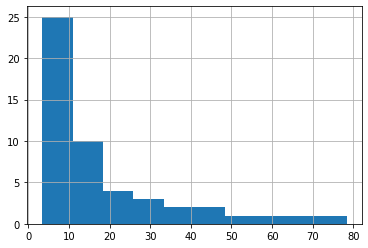

In [29]:
df_words.sum(axis=0).hist()

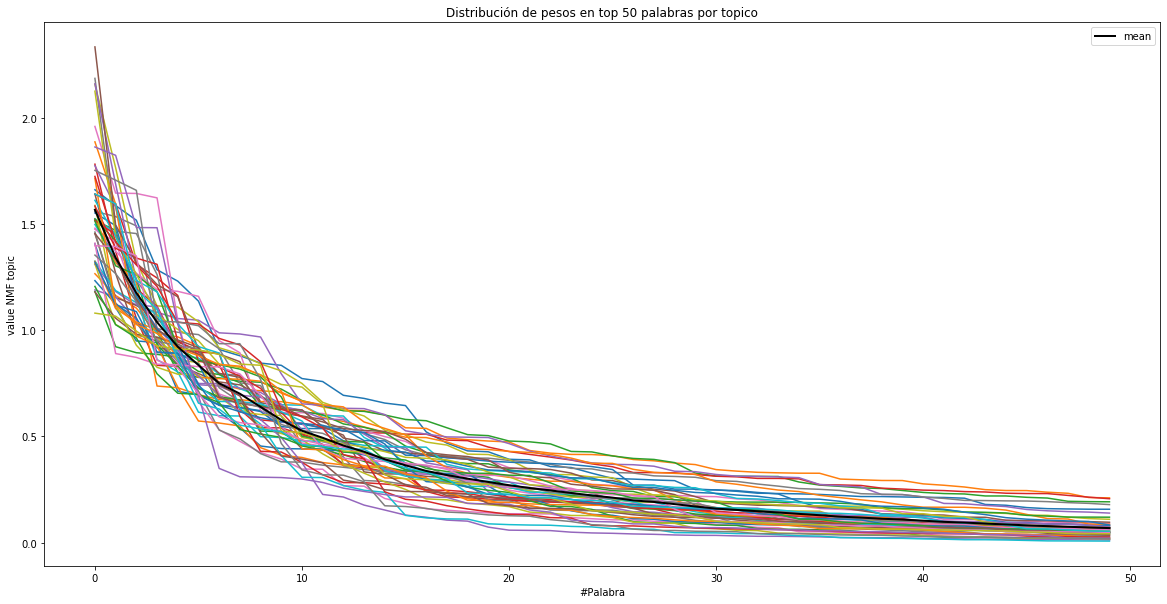

In [30]:
fig = plt.figure(figsize=(20,10))

ax = plt.axes()
numerize = [i for i in range(50)]
for topic in range(df_words.shape[0]):
    x = df_words.iloc[topic,:].values
    ax.plot(numerize,x)
ax.plot(numerize,df_words.mean(axis=0),label="mean",linewidth=2,color="black")
ax.set(xlabel='#Palabra', ylabel='value NMF topic',
       title='Distribución de pesos en top 50 palabras por topico')
ax.legend()
plt.show()

## nombre

In [31]:
df_words_name = pd.DataFrame(index=[number for number in range(df_topicos.shape[0])],
                        columns=["word"+str(numero) for numero in range(20)])
for row in range(df_words_name.shape[0]):
    lista_index = df_topicos.iloc[row,:].nlargest(n=20).index.tolist()
    df_words_name.iloc[row,:] = df_topicos_nombre.reset_index(drop=True).loc[row,lista_index].values

In [32]:
df_words_name.head()

,word0,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10,word11,word12,word13,word14,word15,word16,word17,word18,word19
0,corporal,hormon,cardiovascular,hipertension,obes,etic,ingest,mellitus,arterial,colesterol,sobrepes,consent,insulin,infantil,hig,acuos,adolescent,farmacolog,hepat,clinical
1,materials,pelicul,cristalin,celd,electroquim,precursor,fosil,polimer,hidrocarbur,petrole,fotovolt,semiconductor,atom,hidrogen,combust,polv,nanoestructur,silici,solar,oxidacion
2,hidric,cuenc,semarnat,lluvi,abastec,tomador,acuifer,hidrolog,conagu,vegetacion,faun,rieg,meteorolog,precipitacion,inund,arid,modelacion,coster,ofert,asent
3,anticuerp,antigen,genic,cells,amplificacion,proliferacion,estadi,inmun,purific,tumor,tumoral,linfocit,pulmon,sealizacion,farmacolog,clinical,biopsi,quimioterapi,mutacion,perifer
4,arquitectur,tar,visual,prospect,vide,conceptual,gui,inteligent,aprendizaj,virtual,valoracion,remot,fall,sesion,ponenci,arregl,eventual,torn,pobr,ahorr


# 3. topicos por texto


Asignamos un vectore de topicos para cada texto

In [33]:
lista_topicos = df_topicos.index.tolist()
dataframe_values = pd.DataFrame(columns=lista_topicos, index=[row for row in range(tfidf[:].shape[0])])

In [34]:
topics_results = []
numero_de_matches = 50
for i_doc in range(tfidf[:].shape[0]):

    valor_topico = [np.dot(tfidf[i_doc].todense().tolist()[0],topic_data[topic_id]["value"])
                    for topic_id in range(len(topic_data))] #pesos de topicos
    
    #print([topic["index"] for topic in topic_data])
    #print(i_doc)
    #print(valor_topico)
    #print(np.array([tfidf[i_doc,topic["index"]].sum() for topic in topic_data]) )
    
    #dictionary  = dict(zip(lista_topicos, valor_topico)) # juntar en diccionario palabra-peso
    dictionary = valor_topico
    dataframe_values.iloc[i_doc,:] = valor_topico

    #appendeamos en el DF:
    df_texto_eval.loc[i_doc,"topic_vector"] = str(dictionary)

### TF_idf_vector

In [ ]:
df_texto_eval["tfidf_vector"] = [dict(zip(tfidf_vectorizer.get_feature_names(),tfidf.toarray()[row])) for row in range(len(df_texto_eval))]
df_texto_eval["tfidf_vector"] = [tfidf.toarray()[row] for row in range(len(df_texto_eval))]

In [ ]:
df_texto_eval.head(3)

In [ ]:
df_texto_eval.to_csv("./evaluador_topicos.csv", index=False)

# 4.  Vector por evaluador

a numerico en cols de peso

In [ ]:
dataframe_values[dataframe_values.columns.tolist()[3:]] = dataframe_values[dataframe_values.columns.tolist()[3:]
                                                                          ].apply(pd.to_numeric, errors='coerce')

informacion de proyecto y evaluador

In [ ]:
dataframe_values["CVE_RCEA"] = df_texto_eval[["CVE_RCEA"]]
dataframe_values["USUARIO"] = df_texto_eval[["USUARIO"]]
dataframe_values = dataframe_values.set_index(["CVE_RCEA","USUARIO"]).reset_index(drop=False) # poner campos en primera posicion
dataframe_values.head(2)

In [ ]:
dataframe_values.to_csv("./evaluador-values.topics.csv", index=False)

## Groupy de los pesos por evaluador

In [ ]:
topics_evaluador = dataframe_values.groupby(["CVE_RCEA","USUARIO"])[dataframe_values.columns.tolist()[3:]].mean().reset_index()
topics_evaluador.head()

## para un evaluador, ver cunatos topicos tiene con un thres dado:

In [ ]:
def topicos(x):
    if x > thresh:
        return 1
    else: 
        return 0

In [ ]:
pd_umbral = pd.DataFrame(columns=["sum","umbral"])

In [ ]:

orden_rows = []
for thresh in range(1,13,1):
    thresh = thresh/10
    topicos_thresh_1 = topics_evaluador.iloc[:,2:].applymap(topicos).sum(axis=1)
    topicos_thresh_1 = topicos_thresh_1.to_frame()
    topicos_thresh_1.rename({0:"sum"},axis=1,inplace=True)
    topicos_thresh_1["umbral"] = "umbral=" + str(thresh)
    orden_rows.append(topicos_thresh_1)
    pd_umbral = pd_umbral.append(topicos_thresh_1)

In [ ]:
for i in range(10):
    ax = sns.countplot(orden_rows[i]["sum"])
    sns.set_style("whitegrid")
    ax.set_title('Topicos a asignados a evaluador con ' + orden_rows[i]["umbral"][0] )
    plt.show()

In [ ]:
g = sns.FacetGrid(pd_umbral, row="umbral", row_order=orden_rows,
                  height=1.7, aspect=6,)
sns.set_style("whitegrid")
g = (g.set_axis_labels("4","Total 4(USD)").set(xlim=(-.01,4),ylim=(0,25)))

g.map(sns.distplot, 0);
ax.set(xlabel='common xlabel', ylabel='common ylabel')
plt.show(g)

In [607]:
df

,position,step,walk
0,0,0,0
1,1,1,0
2,1,2,0
3,1,3,0
4,0,4,0
...,...,...,...
95,0,0,19
96,-1,1,19
97,0,2,19
98,1,3,19


In [ ]:
df_texto_eval.to_csv("./model/tf-nmf-por-texto.csv",index=False)



# Pruebas

In [171]:
dataframe_values

,AAA000,AAA001,AAA002,AAA003,AAA004,AAA005,AAA006,AAA007,AAA008,AAA009,...,AAA040,AAA041,AAA042,AAA043,AAA044,AAA045,AAA046,AAA047,AAA048,AAA049
0,0.12797,0.0283803,0.00781384,1.12856,0.00690157,0.0203403,0.0173402,0.00826886,0.0643456,0.136662,...,0.0413495,0.0268434,0.000805323,0.00542768,0.0354491,0.0264948,0.00862395,0.00300107,0.00687647,0.0700447
1,0.0180413,0.0420078,0.00509181,0.100445,0.0279698,0.195337,0.0242623,0.00836641,0.022207,0.16173,...,0.0302384,0.0269948,0.00301279,2.97075e-16,0.00735037,0.00601205,0.11594,0.00773876,0.050249,0.00338127
2,0.0134742,0.0370843,0.236382,0.00147188,0.273292,0.00485405,0.0562036,0.0144402,0.0161882,0.0218863,...,0.00870363,0.0617582,0.0138444,0.515319,0.000356547,0.021907,0.0342619,0.00486186,0.237917,0.0187064
3,0.172884,0.00344604,0.00376001,0.779833,0.0612962,0.0224008,0.0446288,0.00827972,0.0077116,0.0574224,...,0.00309061,0.0117031,0.0683468,0.00385592,0.119446,0.0249189,0.0343577,0.0130187,0.0137989,0.00115869
4,0.114399,0.00229282,0.0338723,0.00645489,0.0856721,0.0918136,0.00354831,0.00191578,0.00212923,0.0425743,...,0.00409864,0.00367395,0.00115988,0.00551441,0.0640077,0.0251829,0.00573918,0.0604373,0.00681527,0.0357244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0317939,0.00887336,0.074339,0.0142952,0.00324506,0.599242,0.029613,0.0208614,0.037473,0.0238594,...,0.074686,0.0175391,0.00374487,0.00438257,0.00854524,0.020218,0.00412083,0.0123863,0.0234988,0.00327762
996,0.148747,0.00456486,0.12401,0.0600373,0.563805,0.00708013,0.0255514,0.00439288,0.0172812,0.0416265,...,0.0370881,0.0815871,0.0291133,0.0651473,0.170219,0.0613785,0.0453004,0.487543,0.000705797,0.018301
997,0.0250189,0.0141451,0.00803219,0.293543,0.00999077,0.249341,0.0235401,0.00167913,0.0334446,0.381303,...,0.00752067,0.170276,0.0179448,0.00100807,0.000669079,0.0220171,0.00201654,0.0414399,0.00873082,0.000954359
998,0.0739968,0.00452548,0.146749,0.00277056,0.173571,0.018703,0,0.00669668,0.0425457,0.0121619,...,0.00090787,0.0194772,0,5.29631e-09,0.0278478,0.00633511,0.00440444,0.018373,0.0642756,0.00209485


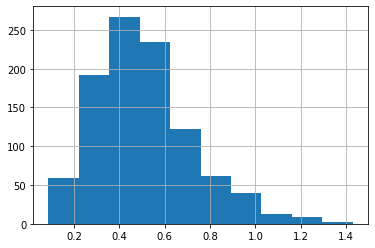

In [199]:
dataframe_values.max(axis=1).hist()

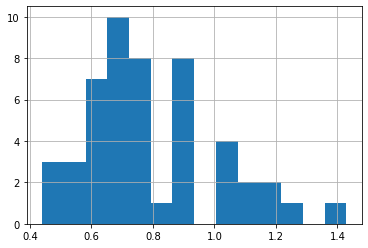

In [200]:
dataframe_values.max(axis=0).hist(bins=14)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  


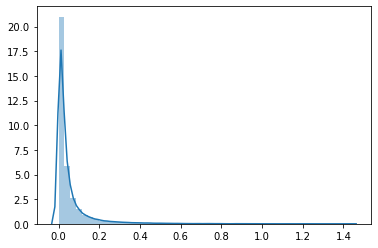

In [186]:
import seaborn as sns
sns.distplot(dataframe_values.values.flatten(1).tolist())

Se guardan en una lista el nombre de los topicos y su puntaje de mayor a menor para cada texto. 


In [290]:
df_texto_eval.head()

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,USUARIO,CVU,NOMBRE,CVE_RCEA,AREA,DISCIPLINA,SUBDISCIPLINA,...,PAIS,ESTADO,DEPENDENCIA,SUBDEPENDENCIA,DESCRIPCION_PROYECTO,PALABRAS_CLAVE1,PALABRAS_CLAVE2,PALABRAS_CLAVE3,topic_vector,tfidf_vector
0,5216,PROBLEMAS-2017-01,2017,X_alicea14434,14434,ALEXEI FEDOROVISH LICEA NAVARRO,RCEA-02-02539-2002,MEDICINA Y CIENCIAS DE LA SALUD,FARMACIA,NaN,...,MEX,DGO,DIVISION DE BIOLOGIA EXPERIMENTAL Y APLICADA,DEPARTAMENTO DE BIOTECNOLOGIA,esper obten inmunoconjug antiegfrviiiac hidrox...,Glioblastoma multiforme,Inmunoconjugados con fitoquimicos,Sintesis enzimatica de fitoquimicos,"{'AAA000': 0.12797012314198503, 'AAA001': 0.02...","{'aceit': 0.0, 'acomp': 0.0, 'acondicion': 0.0..."
1,4341,PROBLEMAS-2016-01,2016,X_lcedillo13822,13822,LETICIA CEDILLO BARRON,RCEA-02-02481-2002,BIOLOGIA Y QUIMICA,BIOLOGIA,NaN,...,MEX,PUE,DEPARTAMENTO DE BIOMEDICINA MOLECULAR,DEPARTAMENTO DE BIOMEDICINA MOLECULAR,antecedent proyect plante estudi interdiscipli...,Virologia,Farmaco,Zika y dengue,"{'AAA000': 0.018041298057112846, 'AAA001': 0.0...","{'aceit': 0.0, 'acomp': 0.0, 'acondicion': 0.0..."
2,4734,PROBLEMAS-2017-01,2017,X_pcerda,216522,PATRICIA LILIANA CERDA PEREZ,RCEA-05-17118-2009,CIENCIAS SOCIALES,CIENCIA POLITICA,NaN,...,MEX,NL,FACULTAD DE CIENCIAS DE LA COMUNICACION,FACULTAD DE CIENCIAS DE LA COMUNICACION,result mejor entend capac ciudad mexican enfre...,Ciudades globales,Medio ambiente,Seguridad ciudadana,"{'AAA000': 0.01347421784599016, 'AAA001': 0.03...","{'aceit': 0.0, 'acomp': 0.0, 'acondicion': 0.0..."
3,6901,PROBLEMAS-2017-01,2017,X_mrobles11767,11767,MARTHA ROBLES FLORES,RCEA-03-02376-2002,MEDICINA Y CIENCIAS DE LA SALUD,MEDICINA,NaN,...,MEX,DF,COORDINACION DE INVESTIGACION CIENTIFICA,FACULTAD DE MEDICINA,esper identific aquell secuenci genic sirv fir...,Biomarcadores circulantes,Cancer de colon y recto,Biomarcadores circulantes y cancer de colonrecto,"{'AAA000': 0.1728837379145187, 'AAA001': 0.003...","{'aceit': 0.0, 'acomp': 0.0, 'acondicion': 0.0..."
4,1932,PROBLEMAS-2015-01,2015,X_mmedina772,772,MARIA ELENA TERESA MEDINA-MORA ICAZA,RCEA-04-04053-2002,MEDICINA Y CIENCIAS DE LA SALUD,CIENCIAS DE LA SALUD,NaN,...,MEXICO,DISTRITO FEDERAL,INSTITUTO NACIONAL DE PSIQUIATRIA RAMON DE LA ...,INSTITUTO NACIONAL DE PSIQUIATRIA RAMON DE LA ...,fenomen consum sustanci psicoact acomp hombr d...,Determinantes,Protectores,Riesgo social de adicciones,"{'AAA000': 0.11439876025440364, 'AAA001': 0.00...","{'aceit': 0.0, 'acomp': 0.007818747952255003, ..."
